# Deep Learning - Exercise 7

The aim of this exercise is to learn how to build unsupervised word embeddings using the Word2Vec Skip-Gram method and implement recurrent neural networks (RNNs) for text generation using Harry Potter books as our dataset.

**Core Concepts**
* 🧠 Word2Vec Skip-Gram model for creating word embeddings
* 📚 Harry Potter corpus for training word embeddings
* 🔤 Analyzing word relationships in embedding space
* ⚡ Text generation using character-based RNNs
* 📝 Creating Harry Potter style stories with generative models

The Word2Vec approach is based on [official Keras tutorial](https://www.tensorflow.org/tutorials/text/word2vec)

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_07.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_07.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization, LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split  #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
import scipy
import itertools
import string
import re
import tqdm
import io

tf.version.VERSION

2025-03-31 20:16:33.733709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743444993.758777   13199 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743444993.767537   13199 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.18.0'

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [4]:
SEED = 13

# 🔎 What is word embedding?
* Why do we use it?
* Do we need to train our own embedding?
* Do the embedding have any other usage beside ANN applications?

# 📒 Word2Vec

## 💡 There are two approaches for a Word2Vec embedding training

* **Continuous bag-of-words model**:
    * predicts the middle word based on surrounding context words.
    * the context consists of a few words before and after the current (middle) word.
    * this architecture is called a bag-of-words model as the order of words in the context is not important.

* **Continuous skip-gram model**:
    * predicts words within a certain range before and after the current word in the same sentence.
    * **we will use this as it is easier concept to grasp**

![w2v](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_skip.png?raw=true)
  
* 📌 Bag-of-words model predicts a word given the neighboring context
* 📌 Skip-gram model predicts the context (or neighbors) of a word, given the word itself

* The model is trained on skip-grams, which are n-grams that allow tokens to be skipped (see the diagram below for an example).
* 💡 The context of a word can be represented through a set of skip-gram pairs of `(target_word, context_word)` where `context_word` appears in the neighboring context of target_word.

## 🔎 What is the difference between Word2Vec or other embeddings and GPT-like models?
* The core idea is the same: Both models need a way to represent words as dense vectors in a continuous vector space
* The models serve different purposes and operate in different ways
    * GPT-like models are focused more on vector-to-vector tasks - generating of text answers
        * e.g. question answering, translation, text completion, ....
    * Traditional models focus rather on vector-to-scalar tasks - classification
        * e.g. sentiment analysis
* Word2Vec embeddings generate fixed-size vector representations for words based on their co-occurrence statistics within a context window
    * These representations do not capture the context in which the word appears in a specific sentence or document
    * 💡 Word2Vec embeddings can be trained on relatively smaller corpora and still capture meaningful semantic relationships between words
* GPT models capture contextual understanding by considering the entire preceding context when generating each token in a sequence
    * This allows them to generate more contextually relevant responses and understand nuances in language better
    * 💡 The model to learn rich representations of language and capture long-range dependencies
    * 💡 GPT models need exposure to a diverse range of linguistic patterns and contexts, which typically requires a large dataset
* 📌 A "crossover" between both approaches are transformer models models like BERT
    * It uses a masked language model (MLM) objective, where random words in a sentence are masked, and the model is trained to predict these masked words based on the surrounding context
    * Additionally, BERT also uses a next sentence prediction (NSP) objective during pre-training to learn sentence-level relationships

## We will demonstrate the Word2Vec working using single sentence

* The context words for each of the 8 words of this sentence are defined by a window size.
    * 💡 The window size determines the span of words on either side of a target_word that can be considered a context word.

![w2v_tab](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_tab.png?raw=true)

## In the first step we will tokenize the sentence

In [5]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split())
print(len(tokens))

8


## Now we can build the vocabulary and mapping WORD -> ID

In [6]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for token in tokens:
    if token not in vocab:
        vocab[token] = index
        index += 1
vocab_size = len(vocab)
print(vocab)

{'<pad>': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}


## It is common to also build also the inverse mapping ID -> WORD

In [7]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: '<pad>', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}


## So int-encoded sentences will look like this one

In [8]:
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[1, 2, 3, 4, 5, 1, 6, 7]


## 📌 We can use the [tf.keras.preprocessing.sequence.skipgrams](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence) to generate skip-gram pairs

*  We will generate skip-grams from the example_sequence with a given window_size from tokens in the range [0, vocab_size)

In [9]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
    example_sequence,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=0,
    seed=int(SEED))
print(len(positive_skip_grams))

26


## ⚡ Let's take a look at some skip-gram examples

In [10]:
for target, context in positive_skip_grams[:5]:
    print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

(1, 4): (the, shimmered)
(4, 1): (shimmered, the)
(5, 4): (in, shimmered)
(7, 1): (sun, the)
(4, 3): (shimmered, road)


## 📒 Negative sampling for one skip-gram

* The skip-gram function returns all positive skip-gram pairs by sliding over a given window span

### 💡 But we also need some negative examples to train the model as well

## 🔎 How can we generate such samples?
* To produce additional skip-gram pairs that would serve as negative samples for training, you need to sample random words from the vocabulary
* Use the `tf.random.log_uniform_candidate_sampler` function to sample `num_ns` number of negative samples for a given target word in a window
    * 💡 You can call the function on one skip-grams's target word and pass the context word as true class to exclude it from being sampled

In [11]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=SEED,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)
print(inverse_vocab[target_word], inverse_vocab[context_word])
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

the shimmered
tf.Tensor([3 0 4 2], shape=(4,), dtype=int64)
['road', '<pad>', 'shimmered', 'wide']


I0000 00:00:1743444996.245295   13199 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [12]:
# Reduce a dimension so you can use concatenation (in the next step).
squeezed_context_class = tf.squeeze(context_class, 1)

# Concatenate a positive context word with negative sampled words.
context = tf.concat([squeezed_context_class, negative_sampling_candidates], 0)

# Label the first context word as `1` (positive) followed by `num_ns` `0`s (negative).
label = tf.constant([1] + [0] * num_ns, dtype="int64")
target = target_word

In [13]:
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 1
target_word     : the
context_indices : [4 3 0 4 2]
context_words   : ['shimmered', 'road', '<pad>', 'shimmered', 'wide']
label           : [1 0 0 0 0]


# The whole process can be illustrated with this example

![w2v_example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_example.png?raw=true)

## Skip-gram sampling table
* A large dataset means larger vocabulary with higher number of more frequent words such as stopwords
* 💡 Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model
    * Subsampling of frequent words as a helpful practice to improve embedding quality

### `sampling_table[i]` denotes the probability of sampling the `i-th` most common word in a dataset.

In [14]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


## ⚡ Compile all the steps described above into a function that can be called on a list of vectorized sentences obtained from any text dataset

In [15]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for `vocab_size` tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            seed=int(SEED),
            negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with a positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=int(SEED),
                name="negative_sampling")

            # Build context and label vectors (for one target word)
            context = tf.concat([tf.squeeze(context_class, 1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0] * num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

## 📒 Now we can download the Harry Potter and the Sorcerer's Stone book and train our own embedding

In [16]:
path_to_file = tf.keras.utils.get_file('hp1.txt',
                                       'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/hp1.txt')

## First 50 lines of the book

In [17]:
with open(path_to_file) as f:
    lines = f.read().splitlines()
for line in lines[:50]:
    print(line)

Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,
because they just didn't hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made
drills. He was a big, beefy man with hardly any neck, although he did
have a very large mustache. Mrs. Dursley was thin and blonde and had
nearly twice the usual amount of neck, which came in very useful as she
spent so much of her time craning over garden fences, spying on the
neighbors. The Dursleys had a small son called Dudley and in their
opinion there was no finer boy anywhere.

The Dursleys had everything they wanted, but they also had a secret, and
their greatest fear was that somebody would discover it. They didn't
think they could bear it if anyone found out about the Potters. Mr

# 🚀 We will employ the *TextLineDataset* from the TF data API
* It allows us to easily load text file line by line and preprocess it
* We will skip the book title and blank lines, then we will remove the CHAPTER XYZ lines as the information is not useful
    * Then we can transform the text into lowercase and remove the punctuation
    * We will use the punctuation from the `re` package

In [18]:
re.escape(string.punctuation)

'!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'

In [19]:
text_ds = tf.data.TextLineDataset(path_to_file).skip(1).filter(lambda x: tf.cast(tf.strings.length(x), bool)).filter(
    lambda y: not tf.strings.regex_full_match(y, 'CHAPTER.*')).map(lambda z: tf.strings.lower(z)).map(
    lambda a: tf.strings.regex_replace(a, f'[{re.escape(string.punctuation)}]', ''))

## Here is our pre-processed dataset

In [20]:
for element in text_ds.take(10).as_numpy_iterator():
    print(element)

b'the boy who lived'
b'mr and mrs dursley of number four privet drive were proud to say'
b'that they were perfectly normal thank you very much they were the last'
b'people youd expect to be involved in anything strange or mysterious'
b'because they just didnt hold with such nonsense'
b'mr dursley was the director of a firm called grunnings which made'
b'drills he was a big beefy man with hardly any neck although he did'
b'have a very large mustache mrs dursley was thin and blonde and had'
b'nearly twice the usual amount of neck which came in very useful as she'
b'spent so much of her time craning over garden fences spying on the'


## The TF dataset works as a data stream
* 💡 The TF dataset uses standard map/reduce API
    * 🔎 How do we iterate over data stream?
    * 🔎 How to count elements?

## Total number of lines in the book

In [21]:
text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + 1).numpy()

np.int32(7628)

## Total length of the text

In [22]:
text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + y).numpy()

np.int32(405596)

## Average length of the text

In [23]:
text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + y).numpy() // text_ds.map(
    lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + 1).numpy()

np.int32(53)

# Now we can setup the `TextVectorization` layer for integer encoding of the tokens
* 💡 It is the same layer as in the sentiment analysis excercise

In [24]:
sequence_length = 15
vectorize_layer = keras.layers.TextVectorization(max_tokens=None, output_mode='int',
                                                 output_sequence_length=sequence_length)
vectorize_layer.adapt(text_ds.batch(1024))

## Vocabulary example

In [25]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('to'), np.str_('a'), np.str_('he'), np.str_('of'), np.str_('harry'), np.str_('was'), np.str_('it'), np.str_('in'), np.str_('his'), np.str_('you'), np.str_('said'), np.str_('had'), np.str_('i'), np.str_('on'), np.str_('at'), np.str_('that')]


## Number of tokens in vocabulary

In [26]:
vocab_size = len(vectorize_layer.get_vocabulary())
vocab_size

6036

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

## 💡 The `unbatch` works in a similar way as the `ravel` in numpy
* i.e. flattening `(n, 1)` shaped array into `(n,)` shaped one
    * e.g. `[[5], [0], [2]]` -> `[5, 0, 2]`

In [28]:
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [29]:
for x in text_vector_ds.take(5).as_numpy_iterator():
    print(x)

[   2  141   74 1071    0    0    0    0    0    0    0    0    0    0
    0]
[ 148    3  258  223    7  616  366  646  534   32 1272    4  157    0
    0]
[  19   20   32 1574  974 1128   13   68  155   20   32    2  143    0
    0]
[ 131  469  789    4   30 1608   11  165  471  102 1421    0    0    0
    0]
[ 140   20   63   56  835   24  497 1844    0    0    0    0    0    0
    0]


## ⚡ We can take a look at number of sequences generated and some examples of the data as well

In [30]:
sequences = list(text_vector_ds.as_numpy_iterator())
len(sequences)

7628

### 🔎 Why are there the `0` ids?

In [31]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[   2  141   74 1071    0    0    0    0    0    0    0    0    0    0
    0] => [np.str_('the'), np.str_('boy'), np.str_('who'), np.str_('lived'), '', '', '', '', '', '', '', '', '', '', '']
[ 148    3  258  223    7  616  366  646  534   32 1272    4  157    0
    0] => [np.str_('mr'), np.str_('and'), np.str_('mrs'), np.str_('dursley'), np.str_('of'), np.str_('number'), np.str_('four'), np.str_('privet'), np.str_('drive'), np.str_('were'), np.str_('proud'), np.str_('to'), np.str_('say'), '', '']
[  19   20   32 1574  974 1128   13   68  155   20   32    2  143    0
    0] => [np.str_('that'), np.str_('they'), np.str_('were'), np.str_('perfectly'), np.str_('normal'), np.str_('thank'), np.str_('you'), np.str_('very'), np.str_('much'), np.str_('they'), np.str_('were'), np.str_('the'), np.str_('last'), '', '']
[ 131  469  789    4   30 1608   11  165  471  102 1421    0    0    0
    0] => [np.str_('people'), np.str_('youd'), np.str_('expect'), np.str_('to'), np.str_('be'), np.str_('invo

## 🚀 Finally we can create the whole dataset

In [32]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=int(SEED))

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 7628/7628 [00:48<00:00, 157.26it/s]




targets.shape: (38615,)
contexts.shape: (38615, 5)
labels.shape: (38615, 5)


In [33]:
targets

array([1071, 1071,  534, ...,  606,   45,  606])

In [34]:
contexts

array([[ 141,  373,   10,  631,  168],
       [  74,  612,    0,    1, 1509],
       [1272,   72, 1017,  234,    1],
       ...,
       [  45,   23,    6,  113,   71],
       [ 606,    2, 1219,   94, 2821],
       [  32,  851,    4, 1903, 1611]])

In [35]:
labels

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

## We will form the dataset using TF data API as well

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets.reshape(-1, 1), contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(64, 1), dtype=tf.int64, name=None), TensorSpec(shape=(64, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 5), dtype=tf.int64, name=None))>


## Performance tweaks
* When the GPU is working on forward / backward propagation on the current batch, we want the CPU to process the next batch of data so that it is immediately ready
* 💡 As the most expensive part of the computer, we want the GPU to be fully used all the time during training
    * We call this consumer / producer overlap, where the consumer is the GPU and the producer is the CPU

* With `tf.data`, you can do this with a simple call to `dataset.prefetch(N)` at the end of the pipeline (after batching).
    * 💡 This will always prefetch `N` batches of data and make sure that there is always `N` batches ready.

In [37]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

## 🚀 The final step is to define and train the model
* We will use 2 `Embedding` layers
    * One for the **target word** and one for the **context words**
* Finally the dot product of the Embedding outputs will be computed to combine the vectors and the result will be taken as an output

In [38]:
embedding_dim = 50

target_input = keras.layers.Input((1,))
context_input = keras.layers.Input((num_ns + 1,))

emb_w2v = keras.layers.Embedding(vocab_size, embedding_dim, name="w2v_embedding",
                                 embeddings_initializer='glorot_uniform')(target_input)
emb_ctx = keras.layers.Embedding(vocab_size, embedding_dim, name="ctx_embedding",
                                 embeddings_initializer='glorot_uniform')(context_input)

dots = keras.layers.dot([emb_w2v, emb_ctx], axes=2)

fl = keras.layers.Flatten()(dots)

# out = keras.layers.Dense(num_ns+1, activation='linear')(fl)

model = keras.Model(inputs=[target_input, context_input], outputs=fl)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ w2v_embedding       │ (None, 1, 50)     │    301,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_embedding       │ (None, 5, 50)     │    301,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 5)      │          0 │ w2v_embedding[0]… │
│                     │                   │            │ ctx_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5)         │          0 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 603,600 (2.30 MB)

 Trainable params: 603,600 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [40]:
model.compile(optimizer=keras.optimizers.AdamW(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
history = model.fit(dataset, epochs=50)

Epoch 1/50


I0000 00:00:1743445066.837889   13263 service.cc:148] XLA service 0x7fc12c004070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743445066.837925   13263 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
I0000 00:00:1743445064.550606   13263 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/603 ━━━━━━━━━━━━━━━━━━━━ -804s -1335879us/step - accuracy: 0.2031 - loss: 1.6095

I0000 00:00:1743445064.931121   13263 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2408 - loss: 1.6038
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3926 - loss: 1.4908
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4915 - loss: 1.3543
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5984 - loss: 1.2069
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6860 - loss: 1.0579
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7514 - loss: 0.9170
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8015 - loss: 0.7893
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8381 - loss: 0.6766
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8664 - loss: 0.5791
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8878 - loss: 0.4961
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9077 - loss: 0.4261
Epoch 12/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

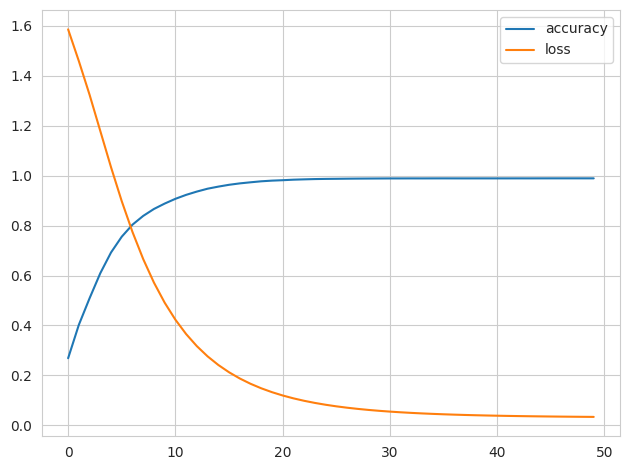

In [42]:
show_history(history)

## ⚡ Now we can save the vectors and visualize it using [TF projector](https://projector.tensorflow.org/)

In [43]:
weights = model.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [44]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

# No Word2Vec tutorial will be ever complete without the similar word search 🙂

In [45]:
id2word = {k: v for k, v in enumerate(vocab)}
word2id = {v: k for k, v in enumerate(vocab)}

# So here we go, we will search the closest vectors for selected words
* 🔎 How is it done?

In [46]:
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]].argsort()[1:6]]
                 for search_term in ['harry', 'hagrid', 'potter', 'go', 'he', 'the', 'one', 'hermione']}

similar_words

(6036, 6036)


{'harry': [np.str_('dreamily'),
  np.str_('curl'),
  np.str_('invisibility'),
  np.str_('towered'),
  np.str_('explained')],
 'hagrid': [np.str_('daughter'),
  np.str_('strangled'),
  np.str_('sounded'),
  np.str_('football'),
  np.str_('wriggles')],
 'potter': [np.str_('important'),
  np.str_('sleeps'),
  np.str_('cloak'),
  np.str_('bravely'),
  np.str_('early')],
 'go': [np.str_('bananas'),
  np.str_('drift'),
  np.str_('frighten'),
  np.str_('persuade'),
  np.str_('manage')],
 'he': [np.str_('bravo'),
  np.str_('glinting'),
  np.str_('creeps'),
  np.str_('health'),
  np.str_('spreading')],
 'the': [np.str_('arrivals'),
  np.str_('promise'),
  np.str_('sounding'),
  np.str_('fight'),
  np.str_('whippy')],
 'one': [np.str_('went'),
  np.str_('footsteps'),
  np.str_('later'),
  np.str_('thumbs'),
  np.str_('law')],
 'hermione': [np.str_('guarding'),
  np.str_('granger'),
  np.str_('talent'),
  np.str_('vol'),
  np.str_('footsteps')]}

# The results are clearly far from ideal 😪
![w2v_meme_01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_meme_01.png?raw=true)

## 🔎 What happend? Did we do anything wrong?

# Ok, let's try again with pre-trained vectors

In [47]:
if not os.path.exists('glove.6B.zip') and not os.path.exists('glove.6B.50d.txt'):
    print("Downloading GloVe embeddings...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
else:
    print("GloVe embeddings already downloaded.")

GloVe embeddings already downloaded.


In [48]:
if os.path.exists('glove.6B.zip') and not os.path.exists('glove.6B.50d.txt'):
    print("Extracting GloVe embeddings...")
    !unzip -q glove.6B.zip
else:
    print("GloVe embeddings already extracted.")

GloVe embeddings already extracted.


In [49]:
path_to_glove_file = 'glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## 💡 This is how the embedding latent vector looks like for the word 'audi' and 'bmw'

In [50]:
embeddings_index['audi']

array([ 0.051355 ,  0.11694  ,  1.0251   ,  0.12414  , -0.83236  ,
        1.0288   , -0.64566  , -1.4468   , -0.89265  , -0.32658  ,
        0.66507  , -0.65524  , -1.8323   , -1.0347   ,  0.13486  ,
       -0.033565 , -0.2208   ,  1.855    , -0.2495   , -0.84343  ,
        0.14318  , -0.81258  , -0.84232  ,  1.1247   , -0.075604 ,
       -0.30852  , -0.79071  ,  0.80721  , -0.24747  , -0.029263 ,
        0.2684   ,  0.6531   ,  0.48872  ,  1.1838   ,  0.5606   ,
       -0.68087  ,  0.25192  ,  0.98091  , -1.0433   , -0.27203  ,
        1.1912   , -0.88594  ,  0.022038 , -0.82012  , -0.0022396,
       -0.68251  ,  0.12713  ,  0.85041  ,  1.002    ,  0.33904  ],
      dtype=float32)

In [51]:
embeddings_index['bmw']

array([ 0.70038 , -0.16073 ,  1.3423  ,  0.63331 , -0.21958 ,  0.31944 ,
       -0.67042 , -0.94041 , -0.56935 , -0.67842 ,  0.39705 , -0.18964 ,
       -2.2101  , -0.90947 ,  0.95511 , -0.01321 , -0.32738 ,  1.1554  ,
       -0.48464 , -1.7606  , -0.051495, -1.0745  , -1.183   ,  0.68672 ,
       -0.107   , -0.42152 , -0.15516 ,  0.12724 , -0.42114 ,  0.30905 ,
        0.59784 ,  0.050149,  0.24022 ,  0.86494 ,  0.63488 , -0.75644 ,
       -0.09189 ,  1.0218  , -0.96638 , -0.90508 ,  0.80575 , -0.75225 ,
        0.7642  , -0.94425 ,  0.4609  ,  0.11877 ,  0.24907 ,  0.066667,
        0.59622 ,  0.1275  ], dtype=float32)

## 💡 Hypothesis: The cosine distance of the car brands should be smaller than with some random word
* 🔎 Why?

In [52]:
cosine(embeddings_index['audi'], embeddings_index['bmw'])

np.float32(0.16636306)

In [53]:
cosine(embeddings_index['audi'], embeddings_index['king'])

np.float32(1.0900573)

## 🚀 For trying the famous `queen -> king` example we need to build the embedding matrix

![w2v_meme_03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_meme_03.png?raw=true)

In [54]:
num_tokens = len(embeddings_index.keys())
embedding_dim = 50
hits = 0
misses = 0
word2id = {k: i for i, (k, v) in enumerate(embeddings_index.items())}
id2word = {v: k for k, v in word2id.items()}

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2id.items():
    embedding_vector = embeddings_index.get(word)
    embedding_matrix[i] = embedding_vector


## Finding the closest words is pretty easy now

In [55]:
c_w = cosine_distances(embedding_matrix[word2id['man']].reshape(-1, 50), embedding_matrix)

In [56]:
for x in c_w.argsort().ravel()[1:6]:
    print(id2word[x])

woman
boy
another
old
one


In [57]:
c_w = cosine_distances(embedding_matrix[word2id['woman']].reshape(-1, 50), embedding_matrix)

In [58]:
for x in c_w.argsort().ravel()[1:6]:
    print(id2word[x])

girl
man
mother
her
boy


## The idea is that using the difference between `man` and `woman` should be simillar as `king` and `queen`
* 💡 Thus it should be possible to use the difference for searching for analogies

In [59]:
dist = embeddings_index['man'] - embeddings_index['woman']

In [60]:
dist

array([ 0.087144  , -0.2182    ,  0.40985996,  0.03922001,  0.10320008,
       -0.94165003,  0.06042001, -0.32988   , -0.46144   ,  0.35962   ,
       -0.31102   ,  0.86824   , -0.96006   , -0.01073003, -0.24337   ,
       -0.08193001,  1.02722   ,  0.21122   , -0.695044  ,  0.00222   ,
       -0.29106003, -0.50530005,  0.099454  , -0.40445   , -0.30181003,
       -0.1355002 ,  0.06060004,  0.07131001,  0.19245   ,  0.06115001,
        0.3204    , -0.07165   ,  0.13337001,  0.25068715,  0.14292999,
        0.224957  ,  0.14899999, -0.048882  , -0.12191002,  0.27362   ,
        0.16547601,  0.20426002, -0.54376   ,  0.27142498,  0.10244995,
        0.32108003, -0.2516    ,  0.33454996,  0.04371002, -0.01258   ],
      dtype=float32)

In [61]:
summed = embeddings_index['queen'] + dist

In [62]:
summed

array([ 0.465684  ,  1.6051    , -0.85494   , -0.06507999,  0.46149006,
       -0.34136003, -0.11496   ,  0.50779   , -0.518238  , -0.39833   ,
       -0.08420999,  1.85411   , -0.35419   , -0.32492003,  0.04539999,
        0.4782    ,  0.25266004,  0.282641  , -1.269144  ,  0.21564001,
        0.28568   , -0.11850005, -0.02628601, -0.12433001, -0.02046004,
       -1.9408002 , -0.9814999 , -0.12123999, -0.3613    ,  0.00662401,
        1.8778    ,  0.32131   , -0.11412999,  0.59319717,  0.59657997,
        0.38732702,  0.67364   , -0.119154  , -0.95935005, -0.75898004,
        0.624936  ,  0.45728   , -0.72213   , -0.46255502, -0.09780005,
        0.55578005, -0.81254995, -1.9493501 ,  0.05298533, -0.61542   ],
      dtype=float32)

In [63]:
res = cosine_distances(summed.reshape(-1, 50), embedding_matrix)

# And here we go 🙂

In [64]:
for x in res.argsort().ravel()[1:6]:
    print(id2word[x])

king
prince
crown
coronation
royal


![w2v_meme_02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_meme_02.png?raw=true)

# We will also learn how to use RNN as a text generator! 🙂
* There are two main ways for solving the task
    * 💡 Word-based model
    * 💡 Character-based model
    
* We have relatively small dataset thus we will use the **Character-based model** as it works better with smaller datasets
    * 💡 We will also simplify the task for using only lower case letters

* 🔎 If we would have very large text corpus available, which way would be better and why?

In [65]:
text_hp = tf.data.TextLineDataset(path_to_file).skip(1).filter(lambda x: tf.cast(tf.strings.length(x), bool)).filter(
    lambda y: not tf.strings.regex_full_match(y, 'CHAPTER.*')).map(lambda z: tf.strings.lower(z))

In [66]:
txt_one_line = ''
for x in text_hp.as_numpy_iterator():
    txt_one_line += str(x)[2:-1]

In [67]:
txt_one_line[:150]

'the boy who livedmr. and mrs. dursley, of number four, privet drive, were proud to saythat they were perfectly normal, thank you very much. they were '

## Build an array of letters from the whole text and filter out everything which is not lower-case letters and spaces

In [68]:
letters = []
for x in txt_one_line:
    if x >= 'a' and x <= 'z' or x == ' ':
        letters.append(x)

In [69]:
letters[:10]

['t', 'h', 'e', ' ', 'b', 'o', 'y', ' ', 'w', 'h']

# We have corpus of 405551 characters available

In [70]:
len(letters)

405551

### 💡 But only 27 unique tokens

In [71]:
chars = sorted(list(set(letters)))
print("Total chars:", len(chars))

Total chars: 27


## We will build `ID -> CHAR` and `CHAR -> ID` lookup tables

In [72]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [73]:
char_indices

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [74]:
indices_char

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

## ⚡ We need to create fixed length sequences for the model
* We will shift the sliding window of `SEQ_LEN` by `step` and for `X,y` pair
    * 💡 Input is array of `SEQ_LEN` letters output is just **1** letter which comes after the sequence

In [75]:
SEQ_LEN = 40
step = 1
X, y = [], []
for i in range(0, len(letters) - SEQ_LEN, step):
    seq, ch = letters[i:i + SEQ_LEN], letters[i + SEQ_LEN]
    X.append(seq)
    y.append(ch)

## Let's take a look at the example
* 💡 Focus on the last letter of the second sequence

In [76]:
print(X[0])

['t', 'h', 'e', ' ', 'b', 'o', 'y', ' ', 'w', 'h', 'o', ' ', 'l', 'i', 'v', 'e', 'd', 'm', 'r', ' ', 'a', 'n', 'd', ' ', 'm', 'r', 's', ' ', 'd', 'u', 'r', 's', 'l', 'e', 'y', ' ', 'o', 'f', ' ', 'n']


In [77]:
print(X[1])

['h', 'e', ' ', 'b', 'o', 'y', ' ', 'w', 'h', 'o', ' ', 'l', 'i', 'v', 'e', 'd', 'm', 'r', ' ', 'a', 'n', 'd', ' ', 'm', 'r', 's', ' ', 'd', 'u', 'r', 's', 'l', 'e', 'y', ' ', 'o', 'f', ' ', 'n', 'u']


In [78]:
y[0]

'u'

### 📌 Characted level RNN uses usually one-hot encoding as we work just with a few unique tokens
* So no complex embedding is needed

In [79]:
X_ohe = np.zeros((len(X), SEQ_LEN, len(chars)), dtype=bool)
y_ohe = np.zeros((len(X), len(chars)), dtype=bool)
for i, sentence in enumerate(X):
    for t, char in enumerate(sentence):
        X_ohe[i, t, char_indices[char]] = 1
    y_ohe[i, char_indices[y[i]]] = 1

In [80]:
X_ohe.shape

(405511, 40, 27)

In [81]:
y_ohe.shape

(405511, 27)

# 🚀 The final step is the model definition and training

In [82]:
input_layer = keras.layers.Input(shape=(SEQ_LEN, len(chars)))
x = LSTM(128, return_sequences=True)(input_layer)
x = LSTM(128, return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(len(chars), activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 128)        │        79,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,859 (1.07 MB)

 Trainable params: 280,859 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

history = model.fit(X_ohe, y_ohe, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs,
                    batch_size=batch_size)

Epoch 1/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.2850 - loss: 2.4573 - val_accuracy: 0.4702 - val_loss: 1.7726
Epoch 2/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 75s 29ms/step - accuracy: 0.4740 - loss: 1.7512 - val_accuracy: 0.5136 - val_loss: 1.5998
Epoch 3/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.5219 - loss: 1.5756 - val_accuracy: 0.5416 - val_loss: 1.5180
Epoch 4/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step - accuracy: 0.5467 - loss: 1.4908 - val_accuracy: 0.5513 - val_loss: 1.4821
Epoch 5/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 74s 29ms/step - accuracy: 0.5655 - loss: 1.4305 - val_accuracy: 0.5598 - val_loss: 1.4514
Epoch 6/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 70s 27ms/step - accuracy: 0.5758 - loss: 1.3896 - val_accuracy: 0.5662 - val_loss: 1.4324
Epoch 7/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 74s 29ms/step - accuracy: 0.5849 - loss: 1.3556 - val_accuracy: 0.5689 - val_loss: 1.4279
Epoch 8/10
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.5933 -

In [84]:
model.load_weights("best.weights.h5")

In [85]:
X_ohe[0].reshape((1, 40, 27))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [86]:
y_pred = model.predict(X_ohe[0].reshape((1, 40, 27)))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [87]:
y_pred

array([2.1096086e-05, 1.2925956e-01, 1.5404469e-06, 2.1061169e-04,
       1.0520852e-05, 2.3454751e-01, 5.3106937e-06, 3.2084448e-05,
       1.5309560e-03, 1.4103056e-01, 5.9268719e-09, 2.8466397e-05,
       5.1620300e-04, 9.9390563e-05, 2.1342952e-04, 4.1424966e-01,
       4.3848555e-05, 1.4749114e-07, 9.0846242e-03, 5.9176123e-06,
       3.7562803e-04, 6.3571796e-02, 1.5650301e-05, 2.9193130e-03,
       1.1797243e-09, 2.2229271e-03, 3.2183355e-06], dtype=float32)

## 📌 We won't use output probabilities directly
* We will sample from the predicted outputs using Temperature Softmax [see this](https://medium.com/@majid.ghafouri/why-should-we-use-temperature-in-softmax-3709f4e0161)

* Basically, the ideas is that it would re-weight the probability distribution so that you can control how much surprising (i.e. higher temperature/entropy) or predictable (i.e. lower temperature/entropy) the next selected character would be
    * 💡 The concept of *Temperature* is used among many generative models
        * e.g. LLMs like [Mixtral-8x7B](https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1)

In [88]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [89]:
c = sample(y_pred)
indices_char[c]

'o'

### 💡 To use the model as a next characted generator for given seed text we need to create a feedback loop

In [90]:
whole_text = X[10].copy()
seq = X[10].copy()
for i in range(500):
    paragraph_ohe = np.zeros((1, SEQ_LEN, len(chars)))
    for t, char in enumerate(seq):
        paragraph_ohe[0, t, char_indices[char]] = 1
    y_pred = model.predict(paragraph_ohe)
    c = sample(y_pred[0], 0.5)
    next_char = indices_char[c]
    whole_text.append(next_char)
    seq = whole_text[-SEQ_LEN:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

#### You can see that the model has only seen character-level data however it has learnt to generate existing words/phrases
* And yes, the output is still far from ideal 🙂
* 🔎 How would you make it better?

In [91]:
''.join(whole_text)

'o livedmr and mrs dursley of number four family and he was here and said like the best back the stone well a fair the chooler who are the potion they were you were you can not to the sorting and which was a lot of the chasers he was down them to get his anger the way the ear and the transfist they were said hagrid and hermione said harry they couldnt see his hand and they was starting the troll dear from the side and a lunches of hereyou be the portraits with his seat and they were the door started to the classes and last his on the d'

# ✅  Tasks for the lecture
* Homework's on vacation mode thanks to the amount of new topics in this lecture, enjoy the break 🙂

Svoboda is homie.